# Using the CCDC python API to search for the MOF structures in the database

Tutorial written by Claire L. Hobday and James Cumby

---

This notebook will try to show you how to search for the MOF structures in the CCDC, and find out structural information about each structure. 


You should have already installed the CSD in full, and this includes the CCDC Python API miniconda. Miniconda is a small version of anaconda (a nice curated version of python). If you have already completed the `interacting_with_the_csd.ipynb` tutorial successfully then your API _should_ work (if not, don't continue here!)

## Initial preparations

In order to run the code in this notebook, we need to load it with access to the ccdc Python API. The following instructions assume you have installed the CSD using default settings, but if not please discuss with us!

1. Start a new command prompt (cmd on Windows, terminal on Mac)
2. Within it, navigate to the location in which you installed the CSD
    On Windows with the default settings, this would be:
    ``` cmd
    cd "C:\Program Files\CCDC\"
    ```
    on MacOS this would be:
    ``` bash
    cd /applications/CCDC/
    ```
3. We now need to activate the miniconda environment installed with the CSD, before modifying it. The first step is to 'activate' the correct API environment so that we can use the CSD Python version.
    On Windows:
    ```
    Python_API_2022\miniconda\scripts\activate
    ```
    On MacOS:
    ```
    source Python_API_2022/miniconda/bin/activate
    ```
    
    The command prompt should now display `(base)` at the start of each line.
4. We need to install Jupyter within the CSD environment in order to load this notebook. To save time, we'll also install ase, which is a package for processing structures in a computer. Type the following: 
   ```
   conda install notebook ase --yes
   ```
   This may take a long while to complete, but should hopefully finish without causing an error.
5. Congratulations! You have now successfully installed Jupyter into your CSD miniconda environment. If you type
   ```
   jupyter notebook
   ```
   into the command prompt this should start a new web browser window containing Jupyter, from which you can navigate to any Jupyter notebook (or create your own).
   Note: If you want to start Jupyter in a specific directory, include that after the notebook command, e.g.
   ```
   jupyter notebook C:\
   ```
   will start in the "C:" directory on Windows
   
For now, "QUIT" Jupyter and close the browser, as we need to install an additional python library to run this tutorial.

---

## Installing PyWindow

This tutorial uses an additional python package (PyWindow) to calculate pore window sizes in MOFs. It is distributed slightly differently to other packages, so we need to install it.


---
1. If you haven't already got a CSD command prompt open, start a new one:

    1. Open a command prompt using `cmd` (Windows) or `terminal` (MacOS)
    2. Navigate to the CSD_2022 directory
    3. Start the CSD environment:
        ` Python_API_2022\miniconda\scripts\activate` on Windows or `source Python_API_2022/miniconda/bin/activate` on MacOS
    4. From here you can start Jupyter (`jupyter notebook`) or an interactive Python terminal (`ipython`)
        - Don't start anything for now! 
---


2. Now, download PyWindow to your own computer (or clone it using git if you know how):
    - You can download it here (https://jelfsmaterialsgroup.github.io/pywindow/)
    - Remember the location you saved it to!

3. In the command prompt, navigate (`cd`) to wherever you put PyWindow
4. type `python setup.py install` to install PyWindow
5. Start Jupyter (`jupyter notebook`) and then load this notebook so we can run our code!


## Setting up and importing all our libraries
---

In [1]:
from ccdc import io, search
from ccdc.interaction import InteractionLibrary
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import glob
import os
import pywindow as pw
from ase.io import read, write
from ase.visualize import view
from ase.atoms import Atom, Atoms


### Reading the list of MOF reference codes
---
Each structure curated by the CSD has a six letter code associated with it. In this folder, you will find a `gcd` file with all the MOF reference codes contained, called `List_mof.gcd`. This list of ordered MOFs contains over 8000 MOF structures and is taken from this reference here: https://pubs.rsc.org/en/content/articlelanding/2020/sc/d0sc01297a#!divAbstract

**This tutorial uses a shorter list of MOF refcodes called `test_mofs.gcd`, just to outline what data processing you can do with the whole MOF dataset**

We can assign this list to a variable (called `file_name` ) to read in the reference code to the CSD, and print out it's reference code. We can then use the CCDC API to find some structural information about it. 

In [2]:
file_name = "test_mofs.gcd"
for line in open(file_name, 'r'):
    refcode = line.rstrip()
    print(refcode)

YOFXEY
YOFXIC
VUNNEZ
DEYNIG
FIKPAR
OBEKOW
GIWXAM
DEYCAN
OQEPUW
HEFVAR
AJOVEB
XAKZAL
IWEDIY
VAJTOR
RAZGOQ
TAHBAH
WATZAU
IFIFAF
XALCIX
SEHXAF
YUNKAV
WATYUN
XALDOE
WUCCAA


Now, we can read in our list of MOF refcodes and analyse them in different ways. 
This tutorial will show you how to use the CCDC API to see what the MOFs are composed of, and how to get some physical parameters such as void volume or window size using the CCDC API or external python programs. 

### Reading in the list and using the CCDC API to understand what its composed of
---

We can read in each refcode and look up its structure in the CSD, and then use some API commands to get out some structural features. 

The features I have chosen below are 
- identifier
- formula
- density
- spacegroup
- void_volume


You can edit this code to look for other parameters, check here for all the different kinds of things you can probe with the API: https://downloads.ccdc.cam.ac.uk/documentation/API/modules/crystal_api.html?highlight=crystal%20crystal#module-ccdc.crystal


In the function below, we write all these features to an easy to read csv file that you can put into excel or origin or use plotting in python to look at the data. 

In [3]:
annotation_csv_path="Test_mof_data.csv"
# Set up readers to read the whole CSD
def write_annotations(annotation_csv_path):
    with open(annotation_csv_path, 'w') as writer:
        writer.write('identifier,formula,density, spacegroup, void_volume\n')

        csd_reader = io.EntryReader('CSD')
        for line in open(file_name, 'r'):
            refcode = line.rstrip()
            current_crystal = csd_reader.crystal(refcode)
            current_molecule = csd_reader.molecule(refcode)
            sg = current_crystal.spacegroup_symbol
            void_vol = round(current_crystal.void_volume(),2)
            
            # write row to CSV
            formula = current_crystal.formula
            density = current_crystal.calculated_density
            writer.write('{},{},{},{},{}\n'.format(
                refcode,
                formula if formula else '',
                density if density else '',
                sg,
                void_vol))

We can then execute this function below like so:

In [4]:
write_annotations(annotation_csv_path)

Take a look at the output CSV file either here in jupyter lab or in excel. You will notice that some of the void volumes are 0.0. This is due to solvent being present in the pores. We do **not** want to include these structures in our modelling of gases, as they wouldn't fit in, so it is a waste of computational resources. We can make a new list of MOFs which doesn't contain structures with no void space. 

### Excluding MOFs with no void_volume
---

This code below will check if the void volumes are zero and exclude them from a new output list of MOFs which will be written to this folder called "VOID_MOFs.gcd". 

We will use this new gcd file to further test MOFs. 

In [5]:
void_mof = []
csd_reader = io.EntryReader('CSD')
for line in open(file_name, 'r'):
    refcode = line.rstrip()
    current_crystal = csd_reader.crystal(refcode)
    void_vol = round(current_crystal.void_volume(),2)
    if void_vol != 0.00:
        void_mof.append(refcode)


        
output = "VOID_MOFs.gcd"
with io.EntryWriter(output) as writer:
    for structure in void_mof:
        #print(structure)
        writer.write(csd_reader.entry(structure))


## Calculate window sizes of MOFs using pywindow
---

There are a few steps to getting this computationally ready:
- get cifs from the refcode
- convert cifs to xyzs
- process the xyzs to get the window sizes out of the MOFs.
- Analyse the data

### Get cifs from the refcode
---

This first part takes the list of reference codes, looks up the structure in the CSD and writes out a cif file into a folder I've made inside this folder called `test_cifs`. 

In [6]:
with io.CrystalReader('VOID_MOFs.gcd', format='identifiers') as reader:
    for crystal in reader:
        with io.CrystalWriter('test_cifs/%s.cif' % crystal.identifier) as writer:
            writer.write(crystal)

### Convert cifs into xyzs
---
The first function here takes a list of cifs we just generated in the folder `test_cifs`. 

Glob reads these and we make a list of the input cif locations in `list_of_cifs`.

We then in the function iterate over these cif files and convert them into xyz files. 
They contain the less information than cifs, only the atom kinds and their coordinates. You can open cifs and xyzs as any standard text file. Have a look at how they are formatted. 

We convert to xyzs as this is the input that pywindow can read, this conversion removes symmetry and treats all atoms as inequivalent and is easier to compute for pywindow! 


In [7]:
list_of_cifs = glob.glob("test_cifs/*.cif")

def convert_cif_to_pdb(list_of_cifs):
    for i in list_of_cifs:
        #read in the cif using ase
        atoms = read(i)
        #name = str(i)
        #name = name.split("/")
        #name = name[1]
        #name = name.split(".")
        #print(name)
        #print(i)
        output_path = os.path.join("mof_xyz", os.path.splitext(os.path.basename(i))[0] + ".xyz")
        write(output_path, atoms)
        


We can then execute this function and give it our list of cifs. This will throw up some "warnings" which show up in *pink*. These are about symmetry of the crystal structure, but these aren't errors - just warnings.
I've checked this out, and everything is processing ok but this is something we should watch!

In [8]:
convert_cif_to_pdb(list_of_cifs)

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 0 and 44 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 0 and 45 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 0 and 46 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 1 and 47 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 1 and 48 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 1 and 49 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\mini

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 39 and 126 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 40 and 127 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 41 and 128 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 42 and 129 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 43 and 130 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 43 and 131 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_A

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 2 and 50 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 7 and 51 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 8 and 52 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 8 and 53 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 9 and 54 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 10 and 55 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\min

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 10 and 58 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 10 and 59 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 10 and 60 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 12 and 61 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 12 and 62 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 13 and 63 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_202

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 48 and 140 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 51 and 141 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 1 and 59 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 2 and 60 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 3 and 61 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\ase\spacegroup\spacegroup.py:435: UserWarning: scaled_positions 4 and 62 are equivalent
  (kinds[ind], kind))
D:\CCDC\Python_API_2022\

### Process xyz to get window sizes of MOFs
---

Now that we have our pdbs in the folder `mof_xyz` we can use pywindow to analyse the window size of our list of xyz. 


This function here will also remove MOF structures which has window sizes that are zero (further reducing the MOFs we might want to calculate, as it is possible to have an enclosed pore - but no window into that porosity). You might want to re-write `VOID_MOFS.gcd` to only include MOFs which have a computed window size. 


There is also much more you can do with pywindow, take a look at the documentation and see how you could edit this code. :) https://marcinmiklitz.github.io/pywindow/


We can then execute this function it will throw up some "warnings" but these do not affect the code. 

In [9]:
def xyz_analyse_window():
    list_of_xyzs = sorted(glob.glob("mof_xyz/*.xyz"))
    names = []
    windows = []
    for xyz in list_of_xyzs:
        try:
            molsys = pw.MolecularSystem.load_file(xyz)
            mol = molsys.system_to_molecule()
            window = mol.calculate_windows()
            if window.size == 0:
                pass
            else:
                windows.append(window)
                name = os.path.splitext(os.path.basename(xyz))[0]
                names.append(name)
        except:
            print(f'Error processing {xyz}')
    return(names, windows)    

In [10]:
names, windows = xyz_analyse_window()

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  window_com = np.array([x, y, z])
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  window_com = np.array([x, y, z])
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Error processing mof_xyz\HEFVAR.xyz
Error processing mof_xyz\IWEDIY.xyz


D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  window_com = np.array([x, y, z])
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  window_com = np.array([x, y, z])
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  window_com = np.array([x, y, z])
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  window_com = np.array([x, y, z])
D:\CCDC\Python_API_2022\miniconda\lib\site-packages\pywindow\utilities.py:1152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Error processing mof_xyz\WATZAU.xyz
Error processing mof_xyz\XALCIX.xyz
Error processing mof_xyz\YOFXEY.xyz
Error processing mof_xyz\YOFXIC.xyz


In [11]:
print(names, windows)

['FIKPAR', 'SEHXAF', 'WATYUN'] [array([1.26488825, 1.38815601]), array([1.32945122, 1.31821243, 1.40484632, 0.797619  ]), array([3.05860647, 0.83323055])]


Above we have printed the output, where each MOF has multiple window sizes. We are only interested in the largest window sizes, so we can loop over all the window sizes for each MOF and report back on the *largest* window size.

In [12]:
large_windows= []
for i in windows:
    large = max(i)
    large_windows.append(large)

In [13]:
print(dict(zip(names, large_windows)))

{'FIKPAR': 1.388156012474798, 'SEHXAF': 1.4048463172410979, 'WATYUN': 3.05860646884263}


Now we can plot our data in a simple bar chart.

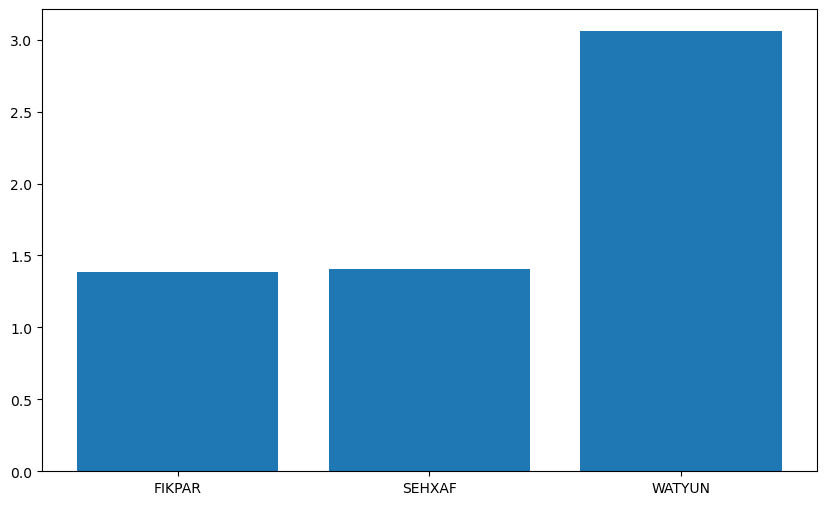

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
ax.bar(names, 
           large_windows)

plt.show()

Ok, that's the end of the tutorial. Now that you've done it for a small section of the MOF database, you can change this code to characterise the whole MOF database. 

Remember that some steps will take more time, e.g. calculating void volumes and window sizes. 